# Conflict Impact Analysis in Middle East, North Africa, Pakistan and Afghanistan

This analysis looks at conflicts between 2020 and 2024 in MENA + AP countries. Using ACLED data, we visualize number of events, conflict and conflict intensity index. 

In [325]:
%reload_ext autoreload
%autoreload 2

import os
import acled_conflict_analysis as acled
from acled_conflict_analysis import visuals
from acled_conflict_analysis import processing
from acled_conflict_analysis import extraction


from bokeh.plotting import show, output_notebook

from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.models import Panel, Tabs, TabPanel

from datetime import date
from datetime import datetime
import geopandas as gpd
import pandas as pd
from conflict_visuals import *


In [2]:
countries_of_interest = [
    "Afghanistan","Pakistan","Algeria","Morocco","Libya","Yemen","Iran", "Iraq",
    "Syria","Egypt","Lebanon","Djibouti","United Arab Emirates","Jordan","Palestine",
    "Oman", "Qatar", "Saudi Arabia", "Kuwait", "Tunisia", "Bahrain"]
START_DATE = "2020-01-01"
END_DATE = "2024-12-31"

In [3]:
os.environ['ACLED_EMAIL'] = extraction.get_acled_credentials()[0]
os.environ['ACLED_KEY'] = extraction.get_acled_credentials()[1]

In [4]:
data = extraction.acled_api(
    email_address=os.environ.get("ACLED_EMAIL"),
    access_key=os.environ.get("ACLED_KEY"),
    countries=countries_of_interest,
    start_date=START_DATE,
    end_date=END_DATE
)

c:\WBG\Anaconda3\envs\acled\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.acleddata.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [5]:
processing.data_type_conversion(data)

In [6]:
extracted_date = datetime.today().strftime('%Y%m%d')

last_date = data['event_date'].max()
last_date = last_date.strftime('%d %B %Y')
extracted_date_formatted = datetime.today().strftime('%d %B %Y')

In [7]:
conflict_national = processing.get_acled_by_group(data, columns=['country'], freq='YS')
conflict_national = conflict_national.groupby(['country'])[['nrEvents', 'nrFatalities']].sum().reset_index()

data_no_protest = data[data['event_type'] != 'Protests']
conflict_national_no_protest = processing.get_acled_by_group(data_no_protest, columns=['country'], freq='YS')
conflict_national_no_protest = conflict_national_no_protest.groupby(['country'])[['nrEvents', 'nrFatalities']].sum().reset_index()

In [8]:
conflict_national_event_type_monthly = processing.get_acled_by_group(data, columns=['country', 'event_type'], freq='MS')
conflict_national_event_type_monthly.to_csv('../../data/conflict/conflict_national_events_monthly_20250723.csv')

## Regional Events and Fatalities

In [379]:
def plot_dual_metrics_by_country(
    data: pd.DataFrame,
    metrics_to_plot: list,
    metric_display_info: dict = None,
    sorting_metric: str = None,
    overall_title: str = 'Comparison of Metrics by Country',
    figsize: tuple = (15, 8)
) -> plt.Figure:
    """
    Generates a dual horizontal bar chart for two specified metrics by country.

    Args:
        data (pd.DataFrame): The input DataFrame containing 'country' and metric columns.
        metrics_to_plot (list): A list of column names (metrics) to visualize.
                                Only the first two valid metrics will be plotted.
        metric_display_info (dict, optional): A dictionary mapping metric names to
            dictionaries with 'title' and 'color' keys.
        sorting_metric (str, optional): The name of the metric to use for sorting countries.
                                        If None, countries are not sorted.
        overall_title (str, optional): The main title for the concatenated chart.
        figsize (tuple, optional): Figure size (width, height). Defaults to (15, 8).

    Returns:
        plt.Figure: A matplotlib Figure object.
    """
    if metric_display_info is None:
        metric_display_info = {}

    df_plot = data.copy()

    # Sort the data if a sorting_metric is provided
    if sorting_metric and sorting_metric in df_plot.columns and pd.api.types.is_numeric_dtype(df_plot[sorting_metric]):
        df_plot = df_plot.sort_values(by=sorting_metric, ascending=True).reset_index(drop=True)
    elif sorting_metric:
        print(f"Warning: Sorting metric '{sorting_metric}' not found or not numeric. Data will not be sorted.")

    # Filter valid metrics and take only the first two for dual plot
    valid_metrics = [m for m in metrics_to_plot if m in df_plot.columns]
    # if len(valid_metrics) < 2:
    #     print("Error: At least two valid metrics are required for a dual bar plot.")
    #     return None
    
    metrics_for_plot = valid_metrics # Take only the first two metrics

    # Create figure and subplots for two metrics
    fig, axes = plt.subplots(1, len(metrics_for_plot), figsize=figsize, sharey=True)

    # Set overall style
    plt.style.use('default')
    fig.patch.set_facecolor('white')

    countries = df_plot['country'].values
    y_pos = np.arange(len(countries))

    for i, metric in enumerate(metrics_for_plot):
        ax = axes[i]
        
        # Get custom title and color, or use defaults
        display_info = metric_display_info.get(metric, {})
        metric_title = display_info.get('title', metric.replace("_", " ").title())
        metric_color = display_info.get('color', plt.cm.Paired(i)) # Use a colormap for default colors
        
        values = df_plot[metric].values

        # Create horizontal bar chart
        bars = ax.barh(y_pos, values, color=metric_color, alpha=0.8,
                       edgecolor='white', linewidth=0.5)

        # Add value labels on bars
        for j, (bar, value) in enumerate(zip(bars, values)):
            width = bar.get_width()
            # Position text slightly to the right of bar end
            ax.text(width + max(values) * 0.01, bar.get_y() + bar.get_height()/2,
                            f'{np.round(value,2):,}', ha='left', va='center', fontsize=9,
                            fontweight='bold', color='black')

        # Customize subplot
        ax.set_yticks(y_pos)
        ax.set_xlabel(f'Number of {metric_title}', fontsize=11, fontweight='bold')
        ax.set_title(f'{metric_title} by Country', fontsize=12, fontweight='bold', pad=15)

        # Only show y-axis labels on leftmost subplot

        ax.set_yticklabels(countries, fontsize=10)
        ax.set_ylabel('Country', fontsize=11, fontweight='bold')
       

        # Style the subplot
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('#CCCCCC')
        ax.spines['bottom'].set_color('#CCCCCC')
        ax.tick_params(colors='#666666')
        ax.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
        ax.set_axisbelow(True)

        # Set x-axis to start from 0 and add some padding
        ax.set_xlim(0, max(values) * 1.15)

    # Add overall title
    fig.suptitle(overall_title, fontsize=16, fontweight='bold', y=0.95)

    # Adjust layout
    plt.tight_layout()
    # Ensure enough space for y-axis labels on the left
    plt.subplots_adjust(left=0.15, top=0.88, bottom=0.05)

    return fig

In [386]:
conflict_national.loc[conflict_national['country']=='West bank and Gaza', 'country'] = 'West Bank and Gaza'
#regional_boundary_grids.loc[regional_boundary_grids['country'] == 'Syrian Arab Republic', 'country'] = 'Syria'

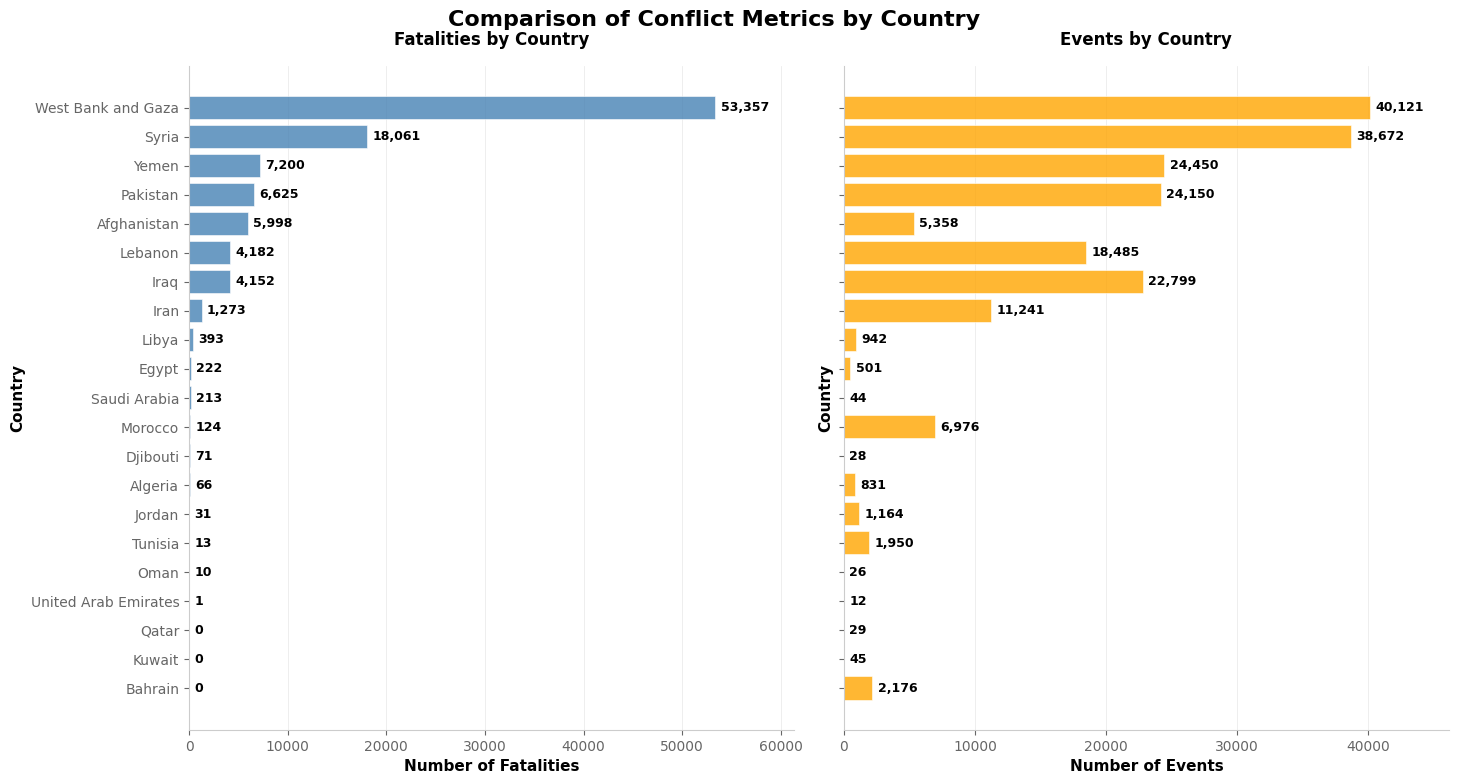

In [387]:
plot_dual_metrics_by_country(
    data =conflict_national,
    metrics_to_plot =['nrFatalities', 'nrEvents'],
    metric_display_info = {'nrFatalities': {'title': 'Fatalities', 'color': 'steelblue'},
                           'nrEvents': {'title': 'Events', 'color': 'orange'}},
    sorting_metric = 'nrFatalities',
    overall_title = 'Comparison of Conflict Metrics by Country',
    #source_text = f'Source: ACLED. Accessed: {extracted_date_formatted}'
);

In [13]:
highest_15 = conflict_national[['country', 'nrFatalities']].sort_values(by='nrFatalities', ascending=False).head(15).reset_index(drop=True)['country'].tolist()

In [15]:
import glob
boundaries_adm0 = gpd.GeoDataFrame()

for file in glob.glob('../../data/boundaries/*_ADM0_*.geojson'):
    gdf = gpd.read_file(file)
    boundaries_adm0 = pd.concat([boundaries_adm0, gdf], ignore_index=True)

boundaries_adm1 = gpd.GeoDataFrame()

for file in glob.glob('../../data/boundaries/*_ADM1_*.geojson'):
    gdf = gpd.read_file(file)
    boundaries_adm1 = pd.concat([boundaries_adm1, gdf], ignore_index=True)

boundaries_adm2 = gpd.GeoDataFrame()

for file in glob.glob('../../data/boundaries/*_ADM2_*.geojson'):
    gdf = gpd.read_file(file)
    boundaries_adm2 = pd.concat([boundaries_adm2, gdf], ignore_index=True)

In [ ]:
#regional_boundary_quadkey7 = gpd.read_file('../../data/boundaries/MENAP_regional_quadkey7.gpkg')
regional_boundary_quadkey12 = gpd.read_file('../../data/boundaries/MENAP_regional_quadkey12.gpkg')
regional_boundary_quadkey12['country'] = regional_boundary_quadkey12['country'].apply(lambda x: get_country_name_from_iso_code(x))

In [264]:
def get_national_conflict_at_aggregation(boundary, index_column, data):
    df = processing.get_acled_by_admin(boundary[[index_column, 'geometry']], data, columns=[index_column, 'country'], freq='YS')
    df = df.groupby([index_column, 'country'])[['nrEvents', 'nrFatalities']].sum().reset_index()
    #df = df.merge(boundary[[index_column, 'geometry']], on=index_column, how='left')
    df = processing.calculate_conflict_index(df)
    df = df.merge(boundary, on=[index_column, 'country'], how='left')
    df= gpd.GeoDataFrame(df, crs='EPSG:4326', geometry='geometry')
    df['region'] = 'Middle East, North Africa, Afghanistan and Pakistan'

    return df

In [32]:
regional_boundary_h3_4 = processing.convert_to_h3_grid(boundaries_adm0, 4)

In [ ]:
conflict_regional_quad12_quarter = processing.get_acled_by_admin(regional_boundary_quadkey12[['index', 'geometry']],data, ['index', 'country'], freq='QS')
conflict_regional_quad12_quarter = processing.calculate_conflict_index(conflict_regional_quad12_quarter)

In [300]:
conflict_regional_quad12_quarter.to_csv('../../data/conflict/conflict_quad12_regional_quarterly.csv')

In [450]:
# conflict_national_h3_4 = get_national_conflict_at_aggregation(regional_boundary_h3_4, 'h3_index')
# conflict_national_q7 = get_national_conflict_at_aggregation(regional_boundary_quadkey7, 'index')
conflict_national_q12 = get_national_conflict_at_aggregation(regional_boundary_quadkey12, 'index', data)
conflict_national_q12_noprotest = data[data['event_type'].isin(['Battles',  'Riots', 
       'Explosions/Remote violence', 'Violence against civilians'])]
conflict_national_q12_noprotest = get_national_conflict_at_aggregation(regional_boundary_quadkey12,'index', conflict_national_q12_noprotest )

In [ ]:
boundaries_quad12.reset_index().to_file('../../data/boundaries/MENAP_regional_quadkey12.gpkg')

## Geospatial Distribution of Conflict Intensity

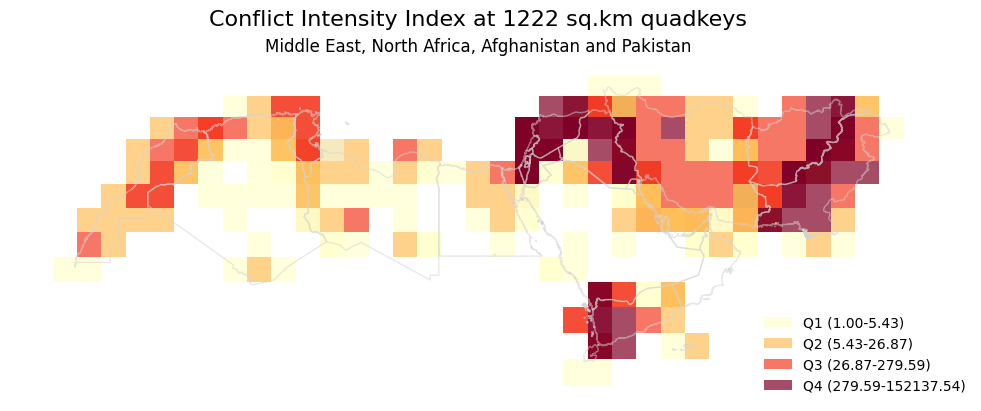

In [269]:
visuals.plot_h3_maps_by_column_value(
    conflict_national_q7,
    title='Conflict Intensity Index at 1222 sq.km quadkeys',
    column_name='region',
    measure='conflict_intensity_index',
    cmap_name='YlOrRd',
    boundary_gdfs_map={'Middle East, North Africa, Afghanistan and Pakistan':boundaries_adm0},
    subtitle_prefix='',
    subplot_figsize_per_map=(10,4));

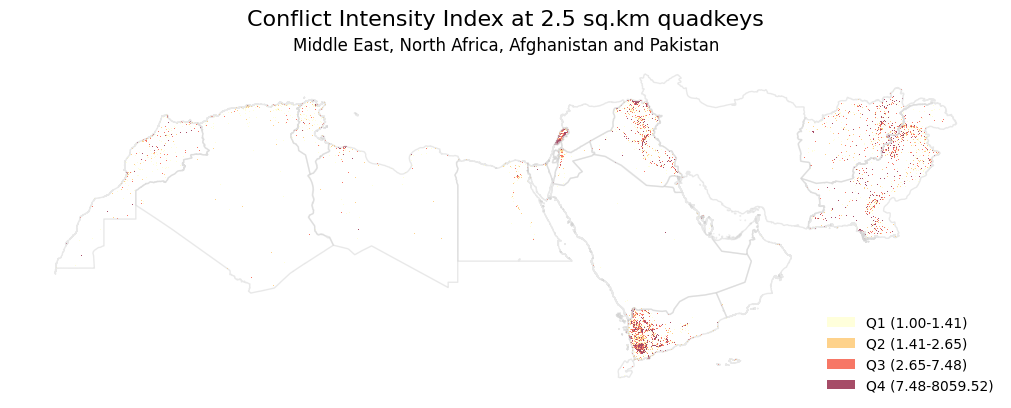

In [270]:
visuals.plot_h3_maps_by_column_value(
    conflict_national_q12,
    title='Conflict Intensity Index at 2.5 sq.km quadkeys',
    column_name='region',
    measure='conflict_intensity_index',
    cmap_name='YlOrRd',
    boundary_gdfs_map={'Middle East, North Africa, Afghanistan and Pakistan':boundaries_adm0},
    subtitle_prefix='',
    subplot_figsize_per_map=(10,4));

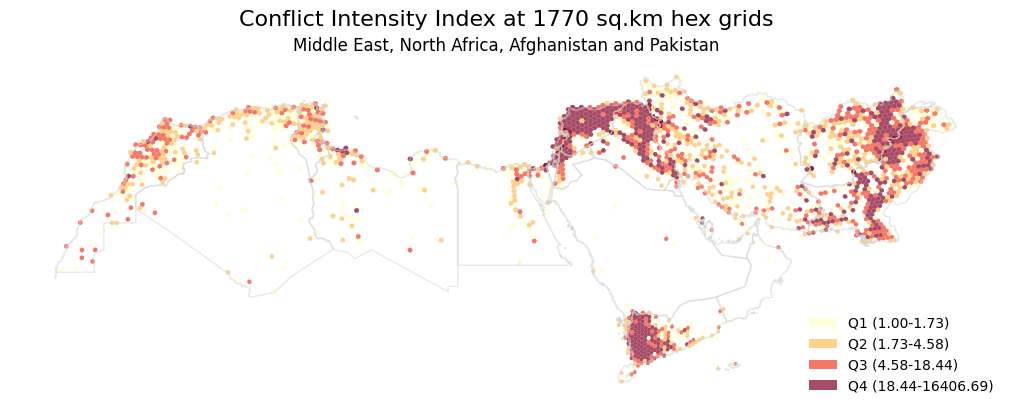

In [271]:
visuals.plot_h3_maps_by_column_value(
    conflict_national_h3_4,
    title='Conflict Intensity Index at 1770 sq.km hex grids',
    column_name='region',
    measure='conflict_intensity_index',
    cmap_name='YlOrRd',
    boundary_gdfs_map={'Middle East, North Africa, Afghanistan and Pakistan':boundaries_adm0},
    subtitle_prefix='',
    subplot_figsize_per_map=(10,4));

In [75]:
conflict_event_monthly = processing.get_acled_by_group(data, columns=['country', 'event_type'], freq='MS')

### Which country saw the most widespread conflict?

1. We divided each country into ~2.4km grids
2. Every grid that had atleast one fatality/events was counted
3. Percentage of area where conflict occured is calculated

In [173]:
regional_boundary_grids = regional_boundary_quadkey12.groupby(['country']).count().reset_index()
regional_boundary_grids.rename(columns={'index':'nrGrids'}, inplace=True)

In [350]:
# Replace specific value in a column
regional_boundary_grids.loc[regional_boundary_grids['country'] == 'Iran, Islamic Republic of', 'country'] = 'Iran'
regional_boundary_grids.loc[regional_boundary_grids['country'] == 'Palestine, State of', 'country'] = 'Palestine'
regional_boundary_grids.loc[regional_boundary_grids['country'] == 'Syrian Arab Republic', 'country'] = 'Syria'

In [372]:
import numpy as np

def get_spread(conflict_national_h3_7, metric, column_name = 'nrGridswithFatalities'):
    conflict_spread = conflict_national_h3_7[conflict_national_h3_7[metric]>0].groupby('country')[metric].count().reset_index()
    print(len(conflict_spread['country'].unique()))
    conflict_spread = conflict_spread.rename(columns={metric:column_name})

    conflict_spread = conflict_spread.merge(regional_boundary_grids, on='country')
    print(len(conflict_spread['country'].unique()))
    conflict_spread['conflictArea'] = np.round(100*conflict_spread[column_name] / conflict_spread['nrGrids'],2)

    return conflict_spread

In [373]:
conflict_spread_fatalities = get_spread(conflict_national_q12, 'nrFatalities')
conflict_spread_events = get_spread(conflict_national_q12, 'nrEvents')

18
18
21
21


In [374]:
conflict_spread_events.rename(columns={'conflictArea': 'conflictAreaEvents'}, inplace=True)
conflict_spread_fatalities.rename(columns={'conflictArea': 'conflictAreaFatalities'}, inplace=True)
conflict_spread = conflict_spread_events.merge(conflict_spread_fatalities, on='country')

In [388]:
conflict_spread.loc[conflict_spread['country'] == 'Palestine', 'country'] = 'West Bank and Gaza'

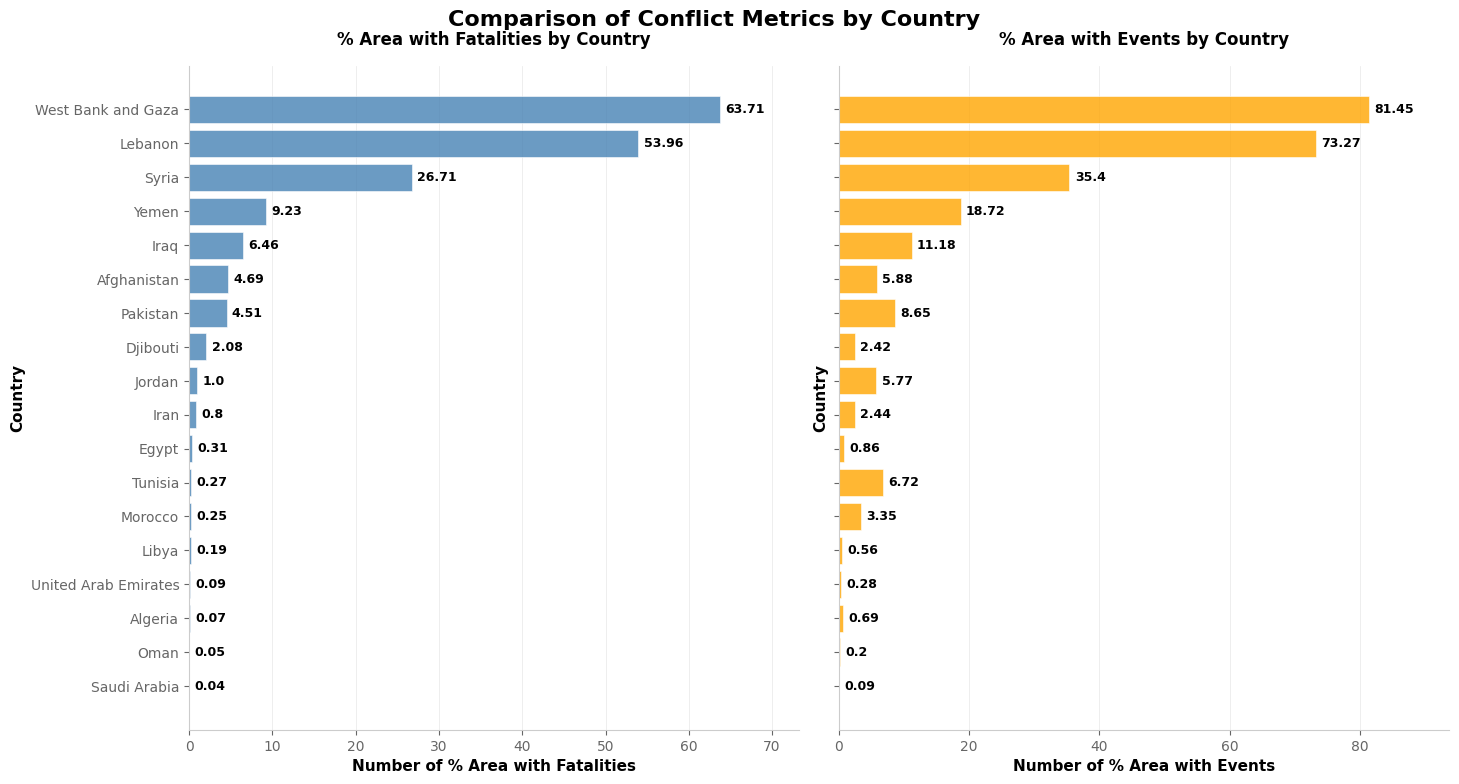

In [389]:
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('default')

plot_dual_metrics_by_country(
    data =conflict_spread,
    metrics_to_plot =['conflictAreaFatalities', 'conflictAreaEvents'],
    metric_display_info = {'conflictAreaFatalities': {'title': '% Area with Fatalities', 'color': 'steelblue'},
                           'conflictAreaEvents': {'title': '% Area with Events', 'color': 'orange'}},
    sorting_metric = 'conflictAreaFatalities',
    overall_title = 'Comparison of Conflict Metrics by Country',
    #source_text = f'Source: ACLED. Accessed: {str(date.today())}'
);

## Conflict Temporal Trends

In [99]:
data['wb_region'] = 'MENAAP'

In [275]:
conflict_regional_yearly = processing.get_acled_by_group(data, ['wb_region'],freq='YS')
conflict_regional_monthly = processing.get_acled_by_group(data, ['wb_region'],freq='MS')

In [102]:
event_dict = {datetime(2023,10,8):'Start of the Gaza War'}

In [105]:
# output_file("bokeh_plot.html")
output_notebook()

df = conflict_regional_monthly
df['region'] = 'MENAAP'

tabs = []
labels = {"nrFatalities": "Number of Fatalities","nrEvents": "Number of Events"}

for idx, type in enumerate(["nrFatalities", "nrEvents"]):
    tabs.append(
        TabPanel(
            child=visuals.get_line_plot(
                df,
                f"National Quarterly Trends in {labels[type]}",
                f"Figure shows annual total fatalities and conflict events, Data is available until {last_date}. \nSource: ACLED. Accessed {extracted_date_formatted}.",
                subtitle="",
                category="region",
                measure=type,
                event_date='event_date',
                #events_dict = event_dict,
                # plot_width=750,
                # plot_height=300
            ),
            title=type.capitalize(),    
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

## Population Impacted by Conflict

How many people were living in the same 2.5sq.km location where conflict events and fatalities occured?

In [453]:
pop = gpd.read_file('../../data/population/polygons/regional_population.gpkg')
pop_country = pop.groupby(['country'])['population'].sum().reset_index()
pop_country.rename(columns={'population':'totalPopulation', 'country':'country_code'}, inplace=True)

In [454]:
pop_country['country'] = pop_country['country_code'].apply(lambda x: get_country_name_from_iso_code(x))

In [455]:
# Replace specific value in a column
pop_country.loc[pop_country['country'] == 'Iran, Islamic Republic of', 'country'] = 'Iran'
pop_country.loc[pop_country['country'] == 'Palestine, State of', 'country'] = 'Palestine'
pop_country.loc[pop_country['country'] == 'Syrian Arab Republic', 'country'] = 'Syria'

In [456]:
code_to_country = pop_country[['country_code', 'country']].drop_duplicates().set_index('country_code').to_dict()['country']
country_to_code = pop_country[['country_code', 'country']].drop_duplicates().set_index('country').to_dict()['country_code']

In [ ]:
conflict_national_q12['country_code'] = conflict_national_q12['country'].map(country_to_code)
conflict_national_q12_noprotest['country_code'] = conflict_national_q12_noprotest['country'].map(country_to_code)

In [458]:
pop.rename(columns={'country': 'country_code'}, inplace=True)
pop['country'] = pop['country_code'].map(code_to_country)

In [460]:
merged = conflict_national_q12.merge(pop[['index', 'population', 'country']],on=['index', 'country'], how='left')
merged = merged.groupby(['country', 'country_code'])[['nrEvents', 'nrFatalities', 'population']].sum().reset_index()
merged = merged.merge(pop_country, left_on ='country_code', right_on='country_code')

In [466]:
merged_noprotest = conflict_national_q12_noprotest.merge(pop[['index', 'population', 'country']],on=['index', 'country'], how='left')
merged_noprotest = merged_noprotest.groupby(['country', 'country_code'])[['nrEvents', 'nrFatalities', 'population']].sum().reset_index()
merged_noprotest = merged_noprotest.merge(pop_country, on=['country', 'country_code'], how='left')

In [467]:
merged_noprotest['pc_population'] = merged_noprotest['population']/merged_noprotest['totalPopulation']

In [293]:
conflict_national_q12.to_file('../../data/conflict/conflict_quad12_regional.gpkg')

In [469]:
merged_noprotest.loc[merged_noprotest['country']=='Palestine', 'country'] = 'West Bank and Gaza'

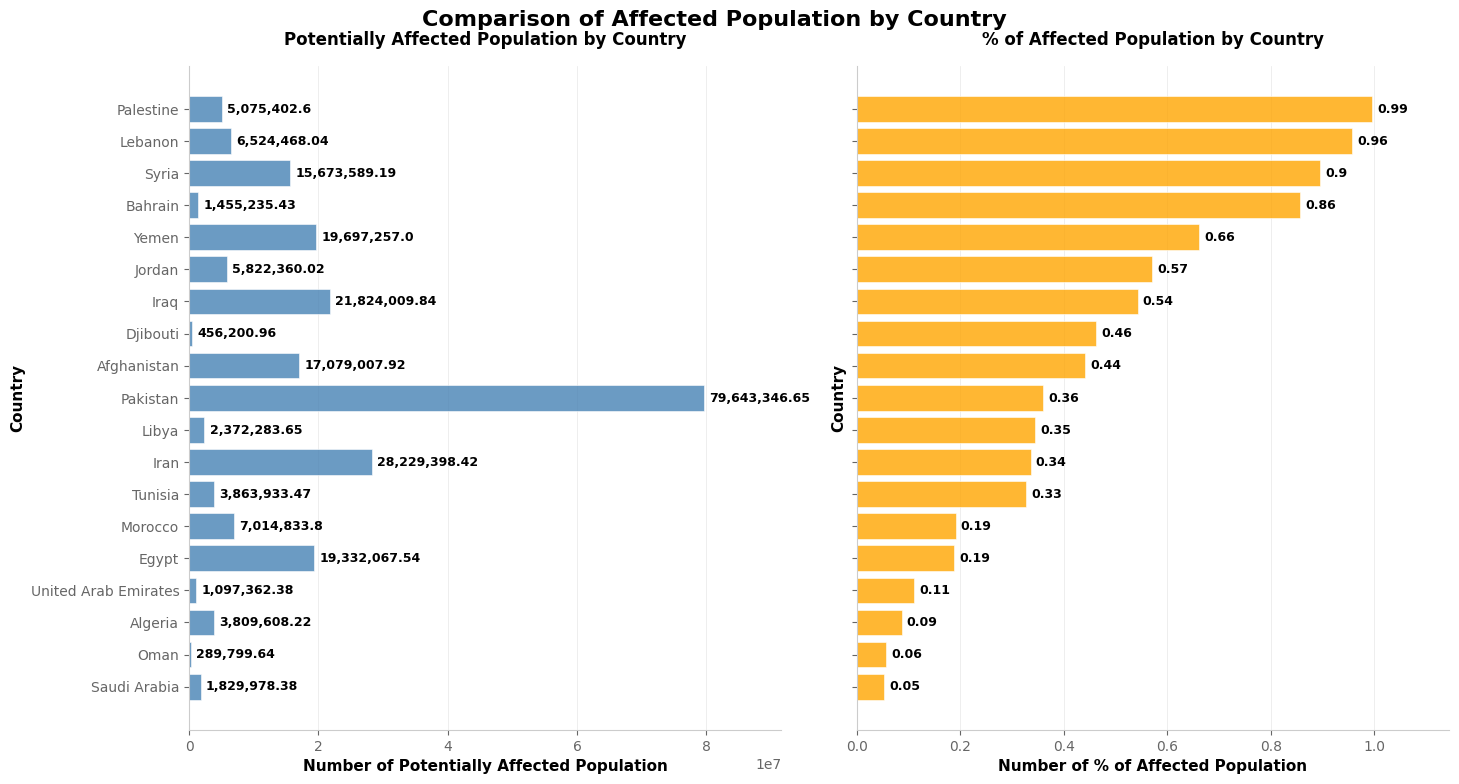

In [468]:
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('default')

plot_dual_metrics_by_country(
    data =merged_noprotest,
    metrics_to_plot =['population', 'pc_population'],
    metric_display_info = {'population': {'title': 'Potentially Affected Population', 'color': 'steelblue'},
                           'pc_population': {'title': '% of Affected Population', 'color': 'orange'}},
    sorting_metric = 'pc_population',
    overall_title = 'Comparison of Affected Population by Country',
    #source_text = f'Source: ACLED. Accessed: {str(date.today())}'
);

**99% of the population of West Bank and Gaza were impacted by the conflict.** While this isn't suprising, 79 million people in Pakistan are also living in conflict regions. Although Bahrain has a lot of conflict events, very few of them result in fatalities. 

## Conflict Type Trends

In [80]:
regional_conflict_event = processing.get_acled_by_group(data, ['event_type', 'sub_event_type'], freq ='MS')

### Regional Conflict Type Analysis

In [83]:
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.models import TabPanel, Tabs # Panel is deprecated in newer Bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
import bokeh.core.validation # Import the module to access silence
bokeh.core.validation.silence(MISSING_RENDERERS, True)
bokeh.core.validation.silence(EMPTY_LAYOUT, True) # Added for completeness if this also occurs

output_notebook() # Ensure this is called if running in a notebook environment

tabs = []

measures = regional_conflict_event['event_type'].unique()

for idx, measure in enumerate(measures):
    # Get the line plot using the provided visuals_module
    p = visuals.get_line_plot(
        regional_conflict_event[regional_conflict_event['event_type']==measure],
        title = f'{measure} Monthly Conflict Events',
        source=f"Source: ACLED. Accessed: {extracted_date_formatted}",
        category='sub_event_type',
        measure='nrEvents',
        event_date='event_date'
    )

    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with tabs
bokeh_tabs_display = Tabs(tabs=tabs, sizing_mode="scale_both")
show(bokeh_tabs_display, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [176]:
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.models import TabPanel, Tabs # Panel is deprecated in newer Bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
import bokeh.core.validation # Import the module to access silence
bokeh.core.validation.silence(MISSING_RENDERERS, True)
bokeh.core.validation.silence(EMPTY_LAYOUT, True) # Added for completeness if this also occurs

output_notebook() # Ensure this is called if running in a notebook environment



tabs = []

measures = countries_of_interest

conflict_event_monthly = conflict_event_monthly.sort_values(by=['country', 'event_type'])

for idx, measure in enumerate(measures):
    # Get the line plot using the provided visuals_module
    p = visuals.get_line_plot(
        conflict_event_monthly[conflict_event_monthly['country'] == measure],
        title = f'{measure} Monthly Conflict Events',
        source="Source: Sentinel 5-P extracted from Google Earth Engine",
        category='event_type',
        measure='nrEvents',
        event_date='event_date'
    )

    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with tabs
bokeh_tabs_display = Tabs(tabs=tabs, sizing_mode="scale_both")
show(bokeh_tabs_display, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [177]:

output_notebook() # Ensure this is called if running in a notebook environment



tabs = []

measures = countries_of_interest

conflict_event_monthly = conflict_event_monthly.sort_values(by=['country', 'event_type'])
df = conflict_event_monthly[conflict_event_monthly['event_type']!='Protests']

for idx, measure in enumerate(measures):
    # Get the line plot using the provided visuals_module
    p = visuals.get_line_plot(
        df[df['country'] == measure],
        title = f'{measure} Monthly Conflict Events (without Protests)',
        source="Source: Sentinel 5-P extracted from Google Earth Engine",
        category='event_type',
        measure='nrEvents',
        event_date='event_date'
    )

    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with tabs
bokeh_tabs_display = Tabs(tabs=tabs, sizing_mode="scale_both")
show(bokeh_tabs_display, warn_on_missing_glyphs=False)

Loading BokehJS ...